# Guidelines

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

! pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! kaggle competitions download -c detecting-french-texts-difficulty-level-2023

from zipfile import ZipFile
with ZipFile('detecting-french-texts-difficulty-level-2023.zip','r') as zip:
  zip.extractall(path="")

import pandas as pd
import numpy as np

Mounted at /content/drive
mkdir: cannot create directory ‘/root/.kaggle’: File exists
detecting-french-texts-difficulty-level-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
df = pd.read_csv('training_data.csv', index_col = 'id')
df.head()

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1


In [ ]:
df_pred = pd.read_csv('unlabelled_test_data.csv', index_col = 'id')
df_pred.head()

,sentence
id,
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."


# Maintenant on code

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize        ##This is used to divide the overall text data to tokens and sentences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer   ##Using the vectorizer to convert values
import tqdm                        ##Used for measuring the time it takes to get the things done
import re                           ##Standard library for reading and substituting the word expressions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import nltk                                ##Used for the natural language processing tasks
import missingno as msno                      ## Used to plot the missing values that are present in our data
from wordcloud import WordCloud               ##It is used to plot the frequency of the words which determines their size
try:
    import plotly.express as px               ##This library is used for interactive visualization
    from plotly import graph_objects as go    ##We also have to use this along with plotly to get interactive visualization
except:
    !pip install plotly
import warnings                       ##We are going to filer some warnings and remove them when we try to import the libraries

nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.snowball import FrenchStemmer #import the French stemming library

# Pour lemmatiser des mots fr
import spacy
!python -m spacy download fr_core_news_sm
nlp = spacy.load('fr_core_news_sm')

# Importer les stopwords français
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


2023-12-05 14:20:10.327562: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 14:20:10.327618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 14:20:10.327661: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 14:20:12.059219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 34.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


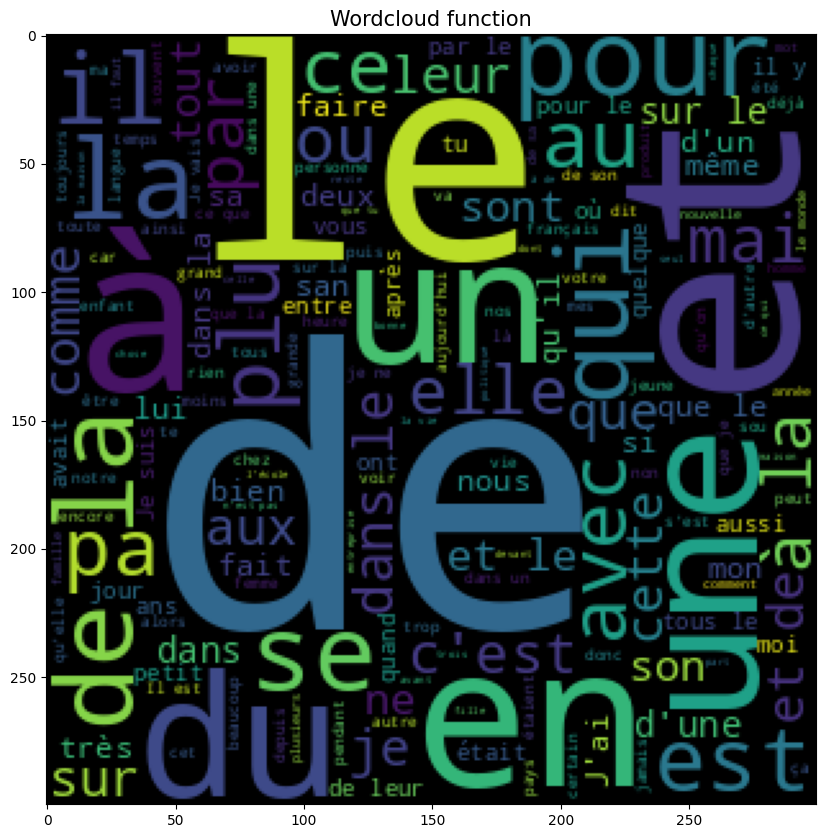

In [ ]:
#Now, we want to create a wordcloud in order to have a better vision of the most common words

def wordcloud_function(df, title, column, fontsize = 15,
                       figsize = (10, 10), width = 300, height = 300):
    total_text = ''.join([text for text in df[column]])
    wordcloud = WordCloud(width = width, height = height).generate(total_text)
    plt.figure(figsize = figsize)
    plt.imshow(wordcloud)
    plt.title(title, fontsize = fontsize)
    plt.show()

wordcloud_function(df, title = "Wordcloud function", column = "sentence")

In [ ]:
#We want to create a lemmatizer to normalise use of verbs
def lemmatizeur(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

In [ ]:
def simplificateur(df):
  text_list = []

  for text in df['sentence'].values:
    text = re.sub('[^a-zA-ZÀ-ÿ]', ' ', text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    lemmatizer = lemmatizeur(' '.join(text))
    text_list.append(lemmatizer)
  text_list = pd.Series(text_list)
  text_list.column = ['Converted_text']
  return(text_list)


In [ ]:
simplified_df = simplificateur(df)
simplified_df.head()

simplified_df_pred = simplificateur(df_pred)

In [ ]:
def infos_importantes(df, stop_words):

    sentences = []
    num_of_words = []
    sent_length = []
    word_length = []
    lemma_length = []
    num_of_lemmas = []
    simplifié_text_length = []
    initial_text_length = []
    num_of_sentences = []
    text_shortage = []

    for text in df['sentence'].values:

      initial_length = len(text)
      initial_text_length.append(initial_length)
      num_sentences = len(sent_tokenize(text))
      num_of_sentences.append(num_sentences)
      text = re.sub('[^a-zA-ZÀ-ÿ]', ' ', text)
      text = text.lower()
      text = word_tokenize(text)
      num_words = len(text)
      num_of_words.append(num_words)
      sent_length.append(num_words/num_sentences)
      word_length.append(initial_length/num_words)
      text = [word for word in text if not word in stop_words]
      text = ' '.join(text)
      doc = nlp(text)
      lemmatized_text = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
      num_lemmas = len(lemmatized_text)
      num_of_lemmas.append(num_lemmas)
      simplifié_text_length_value = len(text)
      simplifié_text_length.append(simplifié_text_length_value)

      if num_lemmas != 0:
        lemma_length.append(simplifié_text_length_value/num_lemmas)
      else:
        lemma_length.append(0)

      text_shortage.append(simplifié_text_length_value/initial_length)

    final_df = pd.concat([pd.Series(sent_length), pd.Series(num_of_words), pd.Series(word_length),
                          pd.Series(lemma_length), pd.Series(num_of_sentences), pd.Series(initial_text_length),
                          pd.Series(num_of_lemmas), pd.Series(simplifié_text_length),
                          pd.Series(text_shortage)], axis = 1)
    final_df.columns = ["sentence_length", "num_of_words", "word_length", "lemma_lengh", "num_of_sentences",
                        "initial_text_length", "num_of_lemmas", "simplifié_text_length", "text_shortage"]

    return final_df

In [ ]:
final_df = infos_importantes(df,stop_words = set(fr_stop))
final_df_pred = infos_importantes(df_pred,stop_words = set(fr_stop))
display(final_df)

,sentence_length,num_of_words,word_length,lemma_lengh,num_of_sentences,initial_text_length,num_of_lemmas,simplifié_text_length,text_shortage
0,40.0,40,6.375000,8.217391,1,255,23,189,0.741176
1,14.0,14,4.428571,5.000000,1,62,7,35,0.564516
2,14.0,14,4.714286,6.000000,1,66,7,42,0.636364
3,9.0,9,4.444444,5.500000,1,40,2,11,0.275000
4,36.0,36,5.805556,6.900000,1,209,20,138,0.660287
...,...,...,...,...,...,...,...,...,...
4795,27.0,27,6.111111,8.230769,1,165,13,107,0.648485
4796,21.0,21,5.619048,7.555556,1,118,9,68,0.576271
4797,13.0,13,6.153846,7.666667,1,80,6,46,0.575000
4798,35.0,35,6.457143,8.631579,1,226,19,164,0.725664


In [ ]:
def convert_difficulty(difficulty):
    if difficulty == 'A1':
        return 0
    elif difficulty == 'A2':
        return 0.2
    elif difficulty == 'B1':
        return 0.4
    elif difficulty == 'B2':
        return 0.6
    elif difficulty == 'C1':
        return 0.8
    elif difficulty == 'C2':
        return 1
    else:
        return None

df = df.assign(convert=df['difficulty'].apply(convert_difficulty))


### Graphiques

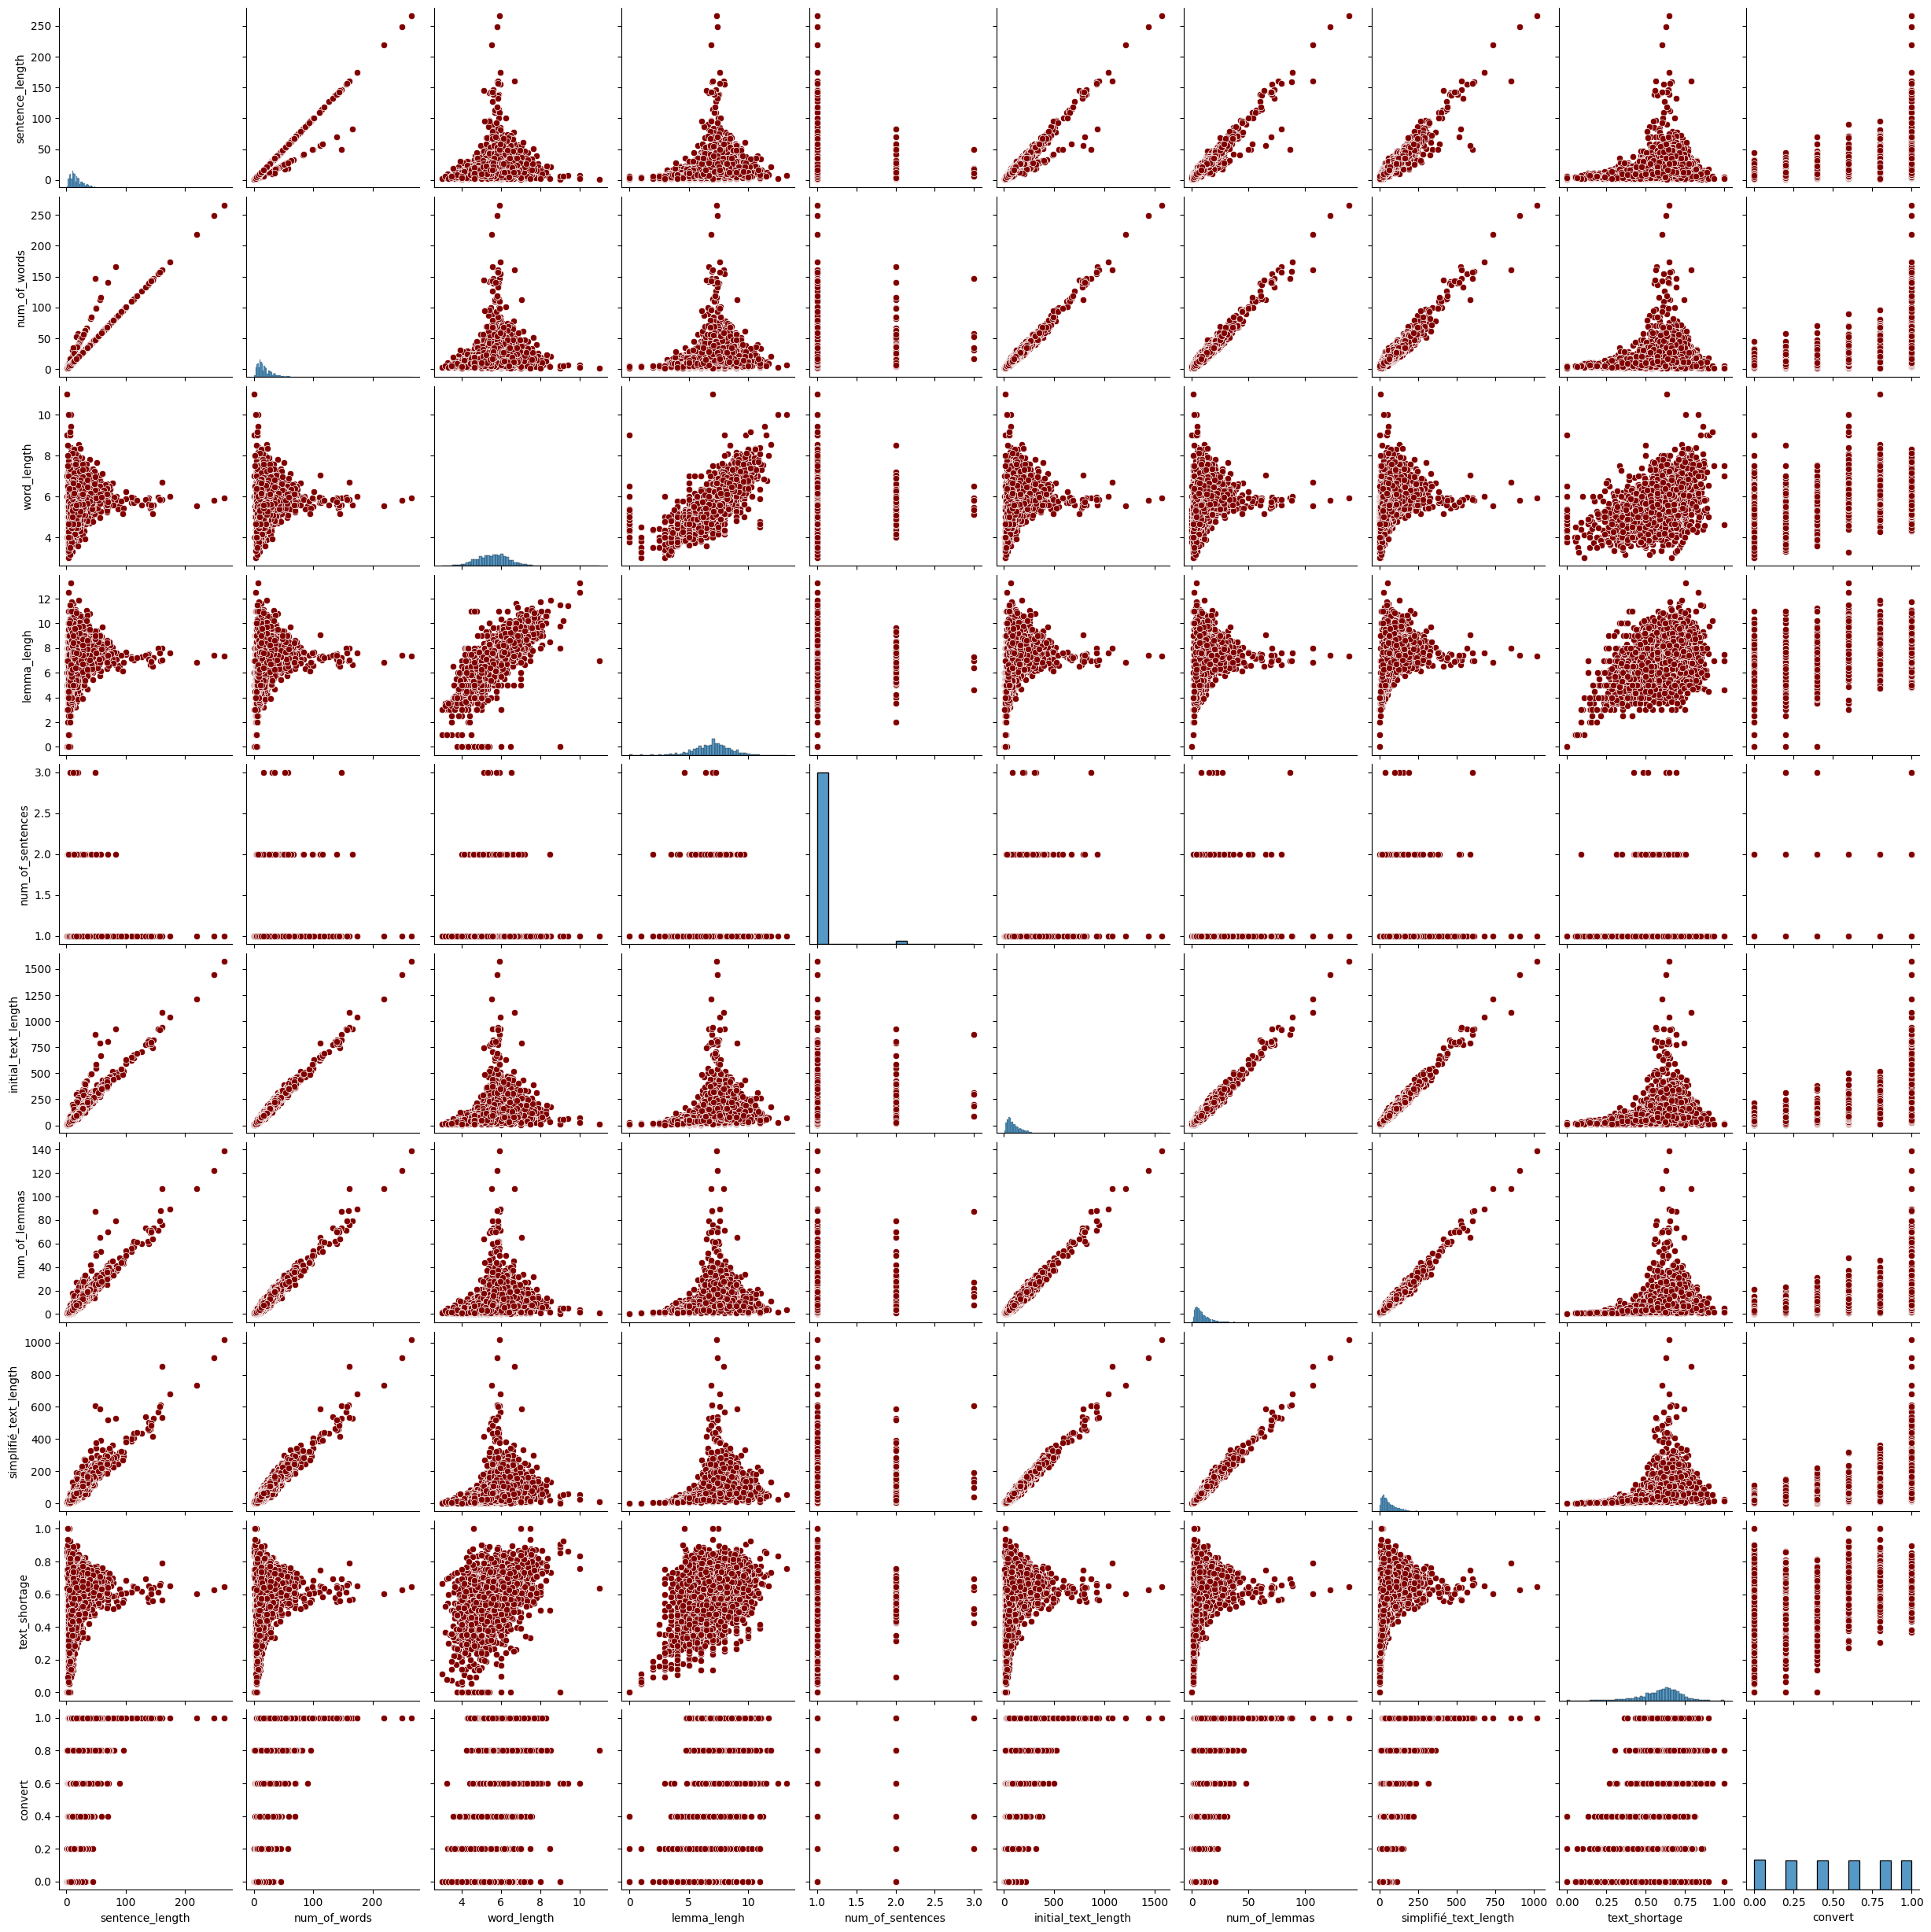

In [ ]:
df_for_plotting = pd.concat([final_df, df["convert"]], axis = 1)
ax = sns.pairplot(data = df_for_plotting, plot_kws = dict(color = "maroon"))
plt.show()

<Axes: >

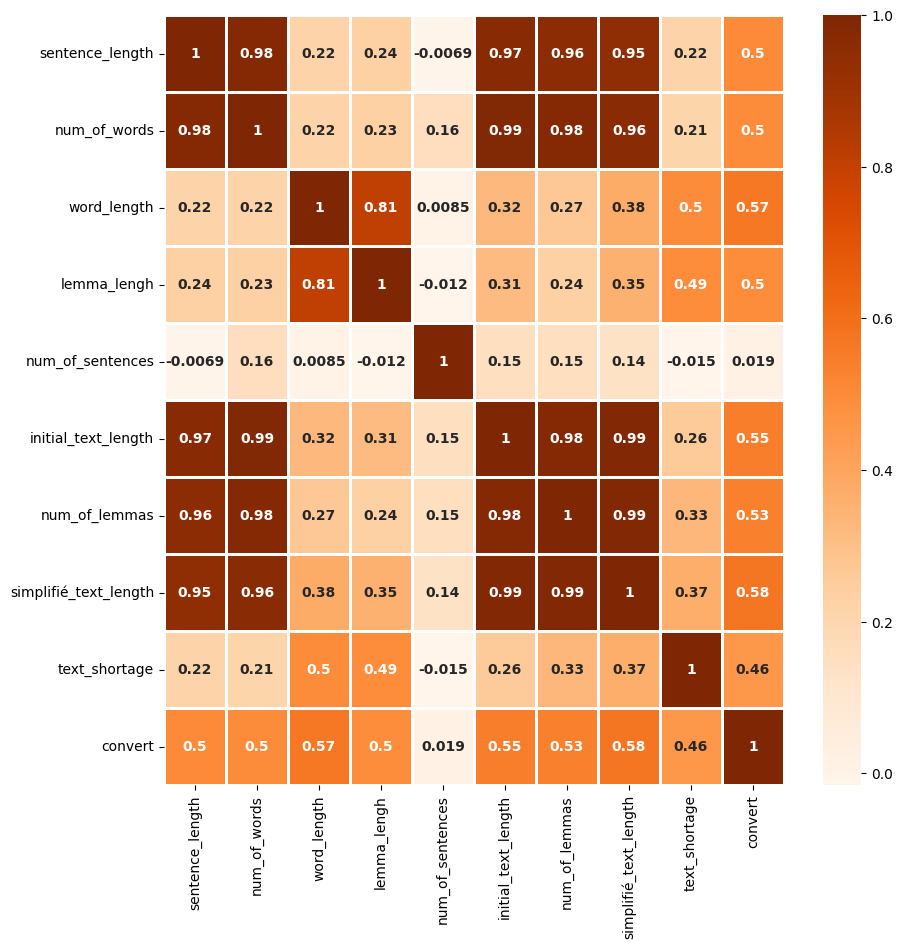

In [ ]:
correlation = df_for_plotting.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(correlation, annot = True, cmap = 'Oranges', linewidths = 1,
           annot_kws = {"weight": "bold", "fontsize": 10})

In [ ]:
def scatterplot_function(df: pd.DataFrame, X, Y, figsize = (10, 10), color = 'orange'):
    plt.figure(figsize = figsize)
    sns.scatterplot(data = df, x = X, y = Y, color = color)
    plt.title(f'Scatterplot between {X} and {Y}')
    plt.show()


### 3.7

In [ ]:
def generate_more_features(df: pd.DataFrame):

    commas = []
    semicolon = []
    exclamations = []
    questions = []
    quotes = []
    periods = []
    longest_word = []

    for i in range(len(df)):

        #word_len = []
        text = df['sentence'].iloc[i]
        commas.append(text.count(","))
        semicolon.append(text.count(";"))
        exclamations.append(text.count("!"))
        questions.append(text.count("?"))
        quotes.append(text.count('"'))
        periods.append(text.count('.'))
        word_len = [len(w) for w in text.split(" ")]
        longest_word.append(np.max(word_len))

    df_with_features =pd.concat((pd.Series(commas), pd.Series(semicolon), pd.Series(exclamations),
                               pd.Series(questions), pd.Series(quotes), pd.Series(periods),
                                pd.Series(longest_word)), axis = 1)
    df_with_features.columns = ["num_of_commas", "num_of_semicolons", "num_of_explamations",
                                "num_of_questions", "num_of_quotes", "num_of_periods",
                                "longest_word"]

    return df_with_features


In [ ]:
df_with_features = generate_more_features(df)
df_with_features_pred = generate_more_features(df_pred)
df_with_features.head()

,num_of_commas,num_of_semicolons,num_of_explamations,num_of_questions,num_of_quotes,num_of_periods,longest_word
0,5,0,0,0,0,1,16
1,1,0,1,0,0,0,8
2,0,0,0,0,0,1,8
3,0,0,0,1,0,0,7
4,2,0,0,0,2,1,12


In [ ]:
df_for_plotting = pd.concat([df_with_features, df['convert']], axis = 1)

<Axes: >

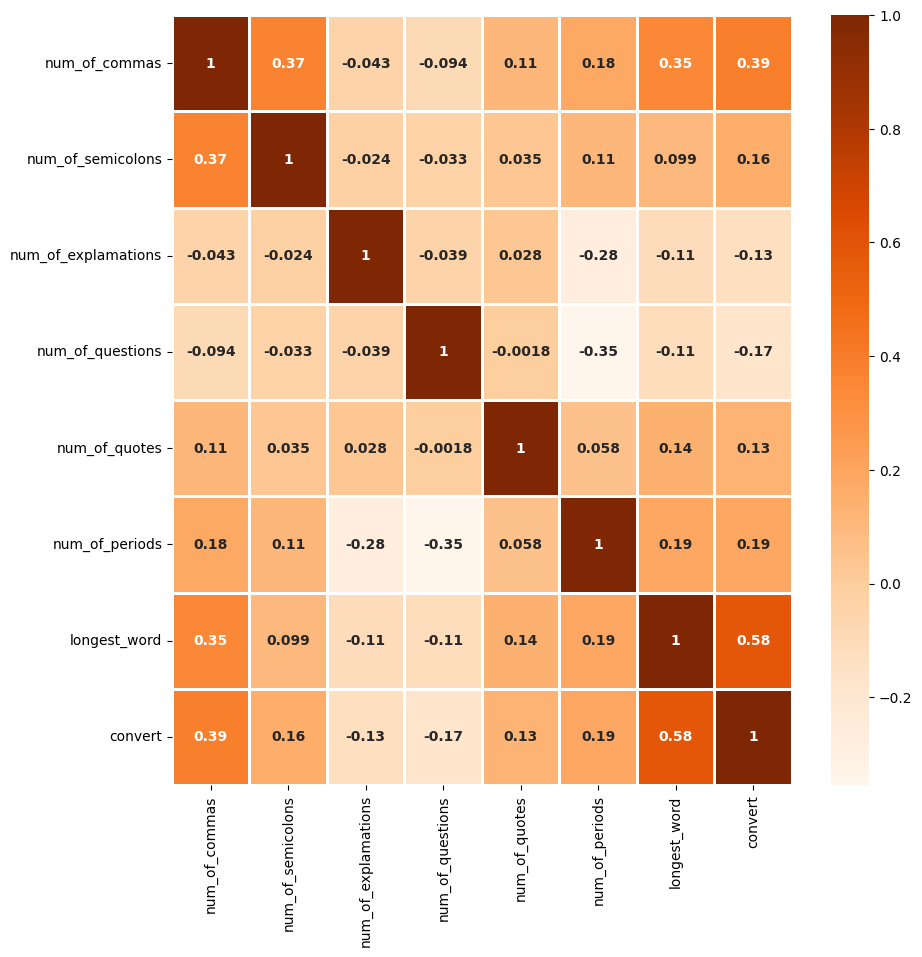

In [ ]:
df_correlation = df_for_plotting.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(df_correlation, annot = True, cmap = 'Oranges', linewidths = 1,
           annot_kws = {"weight": "bold", "fontsize": 10})

In [ ]:
df['text_length'] = final_df['initial_text_length']


In [ ]:
def Count_Vectorizer(df: pd.DataFrame):

  df['sentence'] = df['sentence'].astype(str)
  vectorizer = CountVectorizer()
  vectorizer.fit(df['sentence'])
  converted_vector = vectorizer.transform(df['sentence'])
  return converted_vector

In [ ]:
Count_Vectorizer(df)

<4800x14585 sparse matrix of type '<class 'numpy.int64'>'
	with 76109 stored elements in Compressed Sparse Row format>

In [ ]:
from nltk.corpus import stopwords

### 4.1


In [ ]:
import re

def decontracted(phrase):

    phrase = re.sub(r"l\'", "le", phrase)
    return phrase

In [ ]:
def preprocessing_function(df):
    """
    In this function, we are going to be performing the basic preprocessing
    which is needed before giving to different vectorizers. This ensures that
    we are getting the best output values respectively.
    """

    stopwords_new = fr_stop
    text_list = []
    for i in range(len(df['sentence'])):
        text = df['sentence'].iloc[i]
        text = decontracted(text)
        text = re.sub('[^a-zA-ZÀ-ÿ]', ' ', text)
        text = text.lower()
        text = [word for word in text.split(' ') if not word in stopwords_new]
        text = ' '.join(text)
        # Traitement avec spaCy
        doc = nlp(text)
        # Récupérer les lemmes
        text = [token.lemma_ for token in doc if token.text.lower() not in stopwords_new]
        text_list.append(' '.join(text))
    return text_list

In [ ]:
df_pre = preprocessing_function(df)
df_pre_pred = preprocessing_function(df_pred)

### 4.3

In [ ]:
df_complete = pd.concat((simplified_df, df_with_features, final_df), axis=1)
df_complete_pred = pd.concat((simplified_df_pred, df_with_features_pred, final_df_pred), axis=1)



In [ ]:
vectorizer = TfidfVectorizer()
array_output_values = vectorizer.fit_transform(simplified_df)

In [ ]:
#from tensorflow.keras.layers import Dense, Dropout
#from tensorflow.keras.models import Sequential

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df['sentence'])
df_converted = vectorizer.transform(df['sentence'])

In [ ]:
df_converted

<4800x14585 sparse matrix of type '<class 'numpy.float64'>'
	with 76109 stored elements in Compressed Sparse Row format>

In [ ]:
df_complete_important_features = df_complete.iloc[:, 1:]
df_complete_important_features_pred = df_complete_pred.iloc[:, 1:]

### 4.5

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def min_max_scaler(df_train, df_pred):
    """
    This function performs the scaling operation by taking into account the train and test set respectively. It is going to
    convert the values that are present in the data to lie between 0 and 1 respectively.
    """
    scaler = MinMaxScaler()
    scaler.fit(df_train)
    df_scaled = scaler.transform(df_train)
    df_scaled_pred = scaler.transform(df_pred)
    return df_scaled, df_scaled_pred

In [ ]:
def Tfidf_Vectorizer(df_train, df_pred):
    """
    This function would take the training data and the test data and convert those values which would be in the form of text
    to tfidf values that could be later used for machine learning analysis.
    """
    vectorizer = TfidfVectorizer()
    df_vectorized_train = vectorizer.fit_transform(df_train)
    df_vectorized_pred = vectorizer.transform(df_pred)
    return df_vectorized_train, df_vectorized_pred

In [ ]:
df_scaled, df_scaled_pred = min_max_scaler(df_complete_important_features, df_complete_important_features_pred)

In [ ]:
def Vectorizer_decision(df_train, df_pred):
    vectorized_train, vectorized_pred = Tfidf_Vectorizer(df_train .iloc[:, 0], df_pred.iloc[:, 0])
    return vectorized_train, vectorized_pred

In [ ]:
#df_vectorized, df_vectorized_pred = Vectorizer_decision(df_complete.copy(), df_complete_pred.copy())

In [ ]:
#df_vectorized = df_vectorized.toarray()
#df_vectorized_pred = df_vectorized_pred.toarray()
#df_vectorized_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
df_scaled


(1200, 10045)
(1200, 16)


### 5.1

In [ ]:
df_vectorized, df_vectorized_pred = Vectorizer_decision(df_complete, df_complete_pred)

In [ ]:
df_vectorized = df_vectorized.toarray()
df_vectorized_pred = df_vectorized_pred.toarray()

In [ ]:
X = np.concatenate((df_vectorized, df_scaled), axis = 1)
X_pred = np.concatenate((df_vectorized_pred, df_scaled_pred), axis = 1)
y = df['convert'].values

In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.3, random_state = 50)

### 5.3

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_predict = model.predict(X_cv)


In [ ]:
first_dataframe = pd.DataFrame(pd.Series(y_cv), columns = ['y_actual'])
second_dataframe = pd.DataFrame(pd.Series(y_predict), columns = ['y_predictions'])
final_dataframe = pd.concat((first_dataframe, second_dataframe), axis = 1)

In [ ]:
display(final_dataframe)

,y_actual,y_predictions
0,1.0,0.887445
1,0.2,0.188015
2,0.8,0.868193
3,0.6,0.588989
4,0.2,0.266856
...,...,...
1435,0.2,0.570036
1436,0.0,0.289823
1437,0.0,0.242714
1438,0.4,0.489729


### 6.1

In [ ]:
print("The mean squared error of Gradient Boosting Regressor for cross-validation data is {}".format(mean_squared_error(y_predict, y_cv)))
print("The mean absolute error of Gradient Boosting Regressor for cross-validation data is {}".format(mean_absolute_error(y_predict, y_cv)))


The mean squared error of Gradient Boosting Regressor for cross-validation data is 0.041210195555978976
The mean absolute error of Gradient Boosting Regressor for cross-validation data is 0.15884870658440997


In [ ]:
def unconvert(difficulty):
    if difficulty <= 0.1:
        return 'A1'
    elif difficulty <=0.28:
        return 'A2'
    elif difficulty <=0.5:
        return 'B1'
    elif difficulty <=0.7:
        return 'B2'
    elif difficulty <= 0.87:
        return 'C1'
    elif difficulty >0.87:
        return 'C2'
    else:
        return None

In [ ]:
final = final_dataframe.assign(convert=final_dataframe['y_predictions'].apply(unconvert))
final = final.assign(réel=final['y_actual'].apply(unconvert))
display(final)

,y_actual,y_predictions,convert,réel
0,1.0,0.887445,C2,C2
1,0.2,0.188015,A2,A2
2,0.8,0.868193,C1,C1
3,0.6,0.588989,B2,B2
4,0.2,0.266856,A2,A2
...,...,...,...,...
1435,0.2,0.570036,B2,A2
1436,0.0,0.289823,B1,A1
1437,0.0,0.242714,A2,A1
1438,0.4,0.489729,B1,B1


In [ ]:
accuracy = (final['convert'] == final['réel']).mean()

print(f"L'accuracy est : {accuracy * 100:.2f}%")

L'accuracy est : 39.10%


In [ ]:
y_final = model.predict(X_pred)

In [ ]:
! kaggle competitions submit -c detecting-french-texts-difficulty-level-2023 -f submission.csv -m "UNIL_Rolex"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 408, in authenticate
    self._load_config(config_data)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 449, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.
